<a href="https://colab.research.google.com/github/ajaysinha1804/nailDiseasesAnalysis/blob/main/GoogleNet_with_new_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Dependecies


In [ ]:
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D,Conv2D,MaxPooling2D,BatchNormalization,Concatenate
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, CSVLogger,EarlyStopping,ModelCheckpoint
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
import os
import re
from sklearn.utils import shuffle
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import keras.utils as image

In [ ]:
from keras import backend as K


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Define Paths

In [ ]:
PATH = "/content/drive/MyDrive/datasetnew/"
METRICS_PATH="/content/drive/MyDrive/metro/"
MODEL_NAME="GoogleNet"
print("PWD", PATH)

PWD /content/drive/MyDrive/datasetnew/


# Define Metrics

In [ ]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [ ]:
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    false_positives = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return true_negatives / (true_negatives+false_positives + K.epsilon())

In [ ]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Read Images from Drive

In [ ]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

In [ ]:
data_path = PATH
data_dir_list = sorted_alphanumeric(os.listdir(data_path))
print(data_dir_list)

['Acral Lentiginous Melanoma', 'Bluish Nail', 'Clubbing', 'Healthy Nail', 'Koilonychia', 'Nail Pitting', 'Onychogryphosis', 'onycholysis']


In [ ]:
img_data_list = []

for dataset in data_dir_list:
    img_list = sorted_alphanumeric(os.listdir(data_path + '/' + dataset))
    print('Loaded the images of dataset-' + '{}\n'.format(dataset))
    for img in img_list:
        # print(img)
        img_path = data_path + '/' + dataset + '/' + img
        img = image.load_img(img_path, target_size=(32,32))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        x = x/255
        #print('Input image shape:', x.shape)
        img_data_list.append(x)


Loaded the images of dataset-Acral Lentiginous Melanoma

Loaded the images of dataset-Bluish Nail

Loaded the images of dataset-Clubbing

Loaded the images of dataset-Healthy Nail

Loaded the images of dataset-Koilonychia

Loaded the images of dataset-Nail Pitting

Loaded the images of dataset-Onychogryphosis

Loaded the images of dataset-onycholysis



In [ ]:

img_data = np.array(img_data_list)
# img_data = img_data.astype('float32')
print(img_data.shape)
img_data = np.rollaxis(img_data, 1, 0)
print(img_data.shape)
img_data = img_data[0]
print(img_data.shape)


(8033, 1, 32, 32, 3)
(1, 8033, 32, 32, 3)
(8033, 32, 32, 3)


# Train & Test Data

In [ ]:
27558/2

13779.0

In [ ]:
num_classes = 8
num_of_samples = img_data.shape[0]
print("sample", num_of_samples)
labels = np.ones((num_of_samples,), dtype='int64')
labels[0:859] = 0
labels[859:2191] = 1
labels[2191:3380] = 2
labels[3380:4222] = 3
labels[4222:5121] = 4
labels[5121:5865] = 5
labels[5865:7269] = 6
labels[7269:8033] = 7

names = ['Acral Lentiginous Melanoma', 'Bluish Nail', 'Clubbing', 'Healthy Nail', 'Koilonychia', 'Nail Pitting', 'Onychogryphosis', 'onycholysis']

sample 8033


In [ ]:
Y =to_categorical(labels, num_classes)
x, y = shuffle(img_data, Y, random_state=2)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)


# Model Architecture

In [ ]:
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]
input = Input(shape=(img_height, img_width, channel,))


Conv2D_1 = Conv2D(64, (3,3), activation='relu', padding='same')(input)
MaxPool2D_1 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(Conv2D_1)
BatchNorm_1 = BatchNormalization()(MaxPool2D_1)


tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_1)
tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_1)
tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(BatchNorm_1)
tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)

Conv2D_2 = Conv2D(128, (3,3), activation='relu', padding='same')(output)
MaxPool2D_2 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(Conv2D_2)
BatchNorm_2 = BatchNormalization()(MaxPool2D_2)


tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_2)
tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_2)
tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(BatchNorm_2)
tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)

Conv2D_3 = Conv2D(256, (3,3), activation='relu', padding='same')(output)
MaxPool2D_3 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(Conv2D_3)
BatchNorm_3 = BatchNormalization()(MaxPool2D_3)

tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_3)
tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_3)
tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(BatchNorm_3)
tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)

Output = Flatten()(output)
Output = Dense(num_classes, activation='softmax')(Output)
model = Model(inputs=[input], outputs=[Output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           1792      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 16, 16, 64)           256       ['max_pooling2d[0][0]']   

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy',f1,specificity,sensitivity])

In [ ]:
print((METRICS_PATH+MODEL_NAME+".csv"))

/content/drive/MyDrive/metro/GoogleNet.csv


In [ ]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
csv_logger = CSVLogger(METRICS_PATH+MODEL_NAME+".csv")
model_chekpoint = ModelCheckpoint("GoogleNet.hdf5",monitor = 'val_loss',verbose = 1,save_best_only=True)


# Model Training

In [ ]:
batch_size = 16
data_augmentation = True
epochs = 100

In [ ]:







import time
start = time.time()
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,callbacks=[lr_reducer, csv_logger])
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)  # randomly flip images
    datagen.fit(x_train)
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                            batch_size=batch_size),
                               epochs=epochs,
                               validation_data=(x_test, y_test),callbacks=[lr_reducer,csv_logger])

Using real-time data augmentation.
Epoch 1/100


<ipython-input-20-1769102c3309>:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train, y_train,


402/402 [==============================] - 21s 23ms/step - loss: 1.5977 - accuracy: 0.4303 - f1: 0.3182 - specificity: 0.9825 - sensitivity: 0.2225 - val_loss: 2.0640 - val_accuracy: 0.3143 - val_f1: 0.3040 - val_specificity: 0.9481 - val_sensitivity: 0.2458 - lr: 0.0010
Epoch 2/100
402/402 [==============================] - 6s 16ms/step - loss: 1.3072 - accuracy: 0.5322 - f1: 0.4651 - specificity: 0.9799 - sensitivity: 0.3526 - val_loss: 1.2914 - val_accuracy: 0.5414 - val_f1: 0.5061 - val_specificity: 0.9776 - val_sensitivity: 0.3945 - lr: 0.0010
Epoch 3/100
402/402 [==============================] - 7s 18ms/step - loss: 1.1517 - accuracy: 0.5885 - f1: 0.5457 - specificity: 0.9770 - sensitivity: 0.4427 - val_loss: 1.1588 - val_accuracy: 0.5912 - val_f1: 0.5790 - val_specificity: 0.9772 - val_sensitivity: 0.4767 - lr: 0.0010
Epoch 4/100
402/402 [==============================] - 8s 19ms/step - loss: 1.0682 - accuracy: 0.6229 - f1: 0.5920 - specificity: 0.9762 - sensitivity: 0.4960 - v

# Results

In [ ]:

print('------------Training time is seconds:%s',time.time()-start)
scores = model.evaluate(x_test, y_test, verbose=1)

#history keys and values
print(history.history.keys())
print(history.history.values())

#Metrics for testing
print(scores)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Test f1:',scores[2])
print('Test sensitivity:',scores[3])
print('Test specificity:',scores[4])
print("Max Test accuracy", max(history.history['val_accuracy']))

------------Training time is seconds:%s 809.8287029266357
51/51 [==============================] - 0s 6ms/step - loss: 0.2273 - accuracy: 0.9452 - f1: 0.9461 - specificity: 0.9930 - sensitivity: 0.9418
dict_keys(['loss', 'accuracy', 'f1', 'specificity', 'sensitivity', 'val_loss', 'val_accuracy', 'val_f1', 'val_specificity', 'val_sensitivity', 'lr'])
dict_values([[1.597746729850769, 1.3071805238723755, 1.1517390012741089, 1.0681604146957397, 0.9744971394538879, 0.910480260848999, 0.8413566946983337, 0.8068128824234009, 0.7396330833435059, 0.733363687992096, 0.6886460781097412, 0.6430321931838989, 0.6174550652503967, 0.598656415939331, 0.5728561878204346, 0.5383687615394592, 0.5429883003234863, 0.5251463055610657, 0.49558815360069275, 0.3695054054260254, 0.3080799877643585, 0.2978627383708954, 0.2658901810646057, 0.2422027736902237, 0.24735231697559357, 0.2279728651046753, 0.22425413131713867, 0.2160588502883911, 0.20892301201820374, 0.20281359553337097, 0.19116896390914917, 0.1933236569

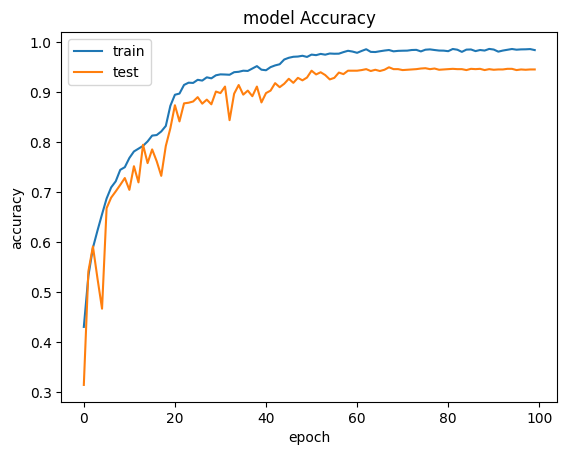

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_acc.png")
plt.show()


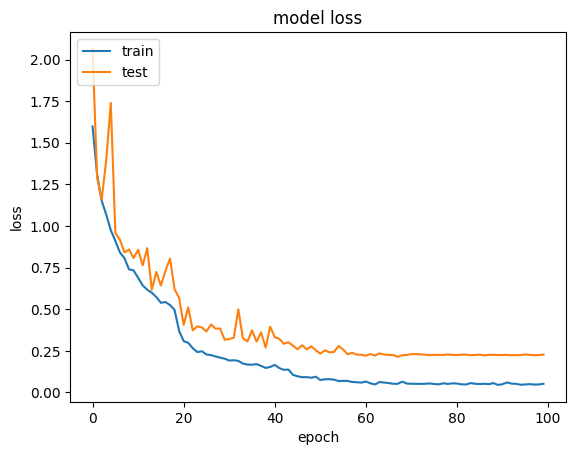

In [ ]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_loss.png")
plt.show()


# without aug

In [ ]:
MODEL_NAME="GoogleNet_waug"

In [ ]:
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]
input = Input(shape=(img_height, img_width, channel,))


Conv2D_1 = Conv2D(64, (3,3), activation='relu', padding='same')(input)
MaxPool2D_1 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(Conv2D_1)
BatchNorm_1 = BatchNormalization()(MaxPool2D_1)


tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_1)
tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_1)
tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(BatchNorm_1)
tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)

Conv2D_2 = Conv2D(128, (3,3), activation='relu', padding='same')(output)
MaxPool2D_2 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(Conv2D_2)
BatchNorm_2 = BatchNormalization()(MaxPool2D_2)


tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_2)
tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_2)
tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(BatchNorm_2)
tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)

Conv2D_3 = Conv2D(256, (3,3), activation='relu', padding='same')(output)
MaxPool2D_3 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(Conv2D_3)
BatchNorm_3 = BatchNormalization()(MaxPool2D_3)

tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_3)
tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_3)
tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(BatchNorm_3)
tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)

Output = Flatten()(output)
Output = Dense(num_classes, activation='softmax')(Output)
model = Model(inputs=[input], outputs=[Output])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_18 (Conv2D)          (None, 32, 32, 64)           1792      ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 16, 16, 64)           0         ['conv2d_18[0][0]']           
 g2D)                                                                                             
                                                                                                  
 batch_normalization_3 (Bat  (None, 16, 16, 64)           256       ['max_pooling2d_6[0][0]'

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy',f1,specificity,sensitivity])

In [ ]:
print((METRICS_PATH+MODEL_NAME+".csv"))

/content/drive/MyDrive/metro/GoogleNet_waug.csv


In [ ]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
csv_logger = CSVLogger(METRICS_PATH+MODEL_NAME+".csv")
model_chekpoint = ModelCheckpoint("GoogleNet_waug.hdf5",monitor = 'val_loss',verbose = 1,save_best_only=True)


In [ ]:
batch_size = 16
data_augmentation = False
epochs = 100

In [ ]:
import time
start = time.time()
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,callbacks=[lr_reducer, csv_logger])
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)  # randomly flip images
    datagen.fit(x_train)
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                            batch_size=batch_size),
                               epochs=epochs,
                               validation_data=(x_test, y_test),callbacks=[lr_reducer,csv_logger])

Not using data augmentation.
Epoch 1/100
402/402 [==============================] - 11s 13ms/step - loss: 1.5332 - accuracy: 0.4659 - f1: 0.3618 - specificity: 0.9832 - sensitivity: 0.2609 - val_loss: 2.7248 - val_accuracy: 0.2097 - val_f1: 0.2033 - val_specificity: 0.9289 - val_sensitivity: 0.1718 - lr: 0.0010
Epoch 2/100
402/402 [==============================] - 5s 13ms/step - loss: 1.1454 - accuracy: 0.5917 - f1: 0.5512 - specificity: 0.9776 - sensitivity: 0.4462 - val_loss: 1.1197 - val_accuracy: 0.6005 - val_f1: 0.5763 - val_specificity: 0.9797 - val_sensitivity: 0.4673 - lr: 0.0010
Epoch 3/100
402/402 [==============================] - 6s 14ms/step - loss: 0.9362 - accuracy: 0.6741 - f1: 0.6508 - specificity: 0.9772 - sensitivity: 0.5652 - val_loss: 1.0622 - val_accuracy: 0.6304 - val_f1: 0.6112 - val_specificity: 0.9759 - val_sensitivity: 0.5202 - lr: 0.0010
Epoch 4/100
402/402 [==============================] - 4s 11ms/step - loss: 0.8136 - accuracy: 0.7202 - f1: 0.7080 - spec

In [ ]:

print('------------Training time is seconds:%s',time.time()-start)
scores = model.evaluate(x_test, y_test, verbose=1)

#history keys and values
print(history.history.keys())
print(history.history.values())

#Metrics for testing
print(scores)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Test f1:',scores[2])
print('Test sensitivity:',scores[3])
print('Test specificity:',scores[4])
print("Max Test accuracy", max(history.history['val_accuracy']))

------------Training time is seconds:%s 505.0967710018158
51/51 [==============================] - 0s 6ms/step - loss: 1.0152 - accuracy: 0.8500 - f1: 0.8542 - specificity: 0.9800 - sensitivity: 0.8499
dict_keys(['loss', 'accuracy', 'f1', 'specificity', 'sensitivity', 'val_loss', 'val_accuracy', 'val_f1', 'val_specificity', 'val_sensitivity', 'lr'])
dict_values([[1.5331549644470215, 1.145440697669983, 0.9362305402755737, 0.8136338591575623, 0.713524341583252, 0.5809427499771118, 0.5069909691810608, 0.4227791428565979, 0.37584537267684937, 0.3289467394351959, 0.2747785747051239, 0.25908923149108887, 0.2393849492073059, 0.22101032733917236, 0.1947980374097824, 0.15777701139450073, 0.059080660343170166, 0.01897396333515644, 0.016576776280999184, 0.010210562497377396, 0.016628388315439224, 0.011034631170332432, 0.005758730694651604, 0.005504956003278494, 0.004457477945834398, 0.005756865721195936, 0.004643588326871395, 0.004309730138629675, 0.002169832354411483, 0.0028113883454352617, 0.00

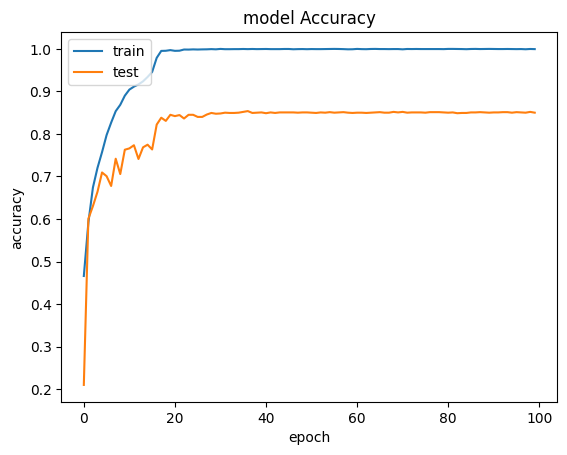

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_acc.png")
plt.show()


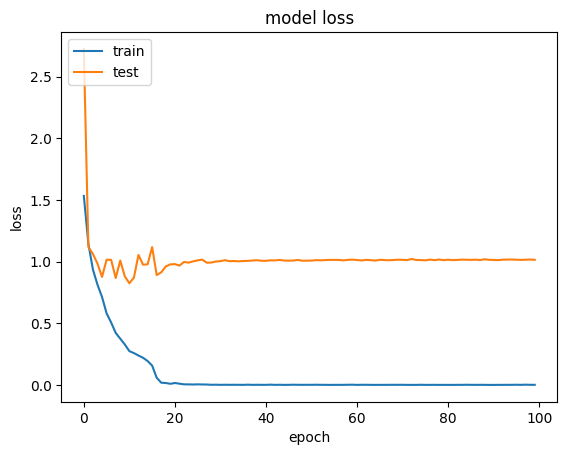

In [ ]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_loss.png")
plt.show()
